In [1]:
## main
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from imblearn.over_sampling import SMOTE
from PIL import Image

## skelarn -- preprocessing
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline, FeatureUnion

## skelarn -- models
# from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
# from sklearn.linear_model import LogisticRegression

## sklearn -- metrics
from sklearn.metrics import f1_score, confusion_matrix


In [2]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
        
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[self.attribute_names].values

In [3]:
TRAIN_PATH = os.path.join(os.getcwd(), "dataset.csv")
df = pd.read_csv(TRAIN_PATH)
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [4]:
df.drop(columns=["CustomerId" , "RowNumber" , "Surname"], inplace=True)

In [5]:
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  int64  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB


In [7]:
df.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [8]:
df.duplicated().sum() # check for duplicates

0

In [9]:
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [10]:
class OutlierHandler(BaseEstimator, TransformerMixin):
    def __init__(self, method="iqr", factor=1.5):
        self.method = method
        self.factor = factor
    
    def fit(self, X, y=None):
        
        if self.method == "iqr":
            Q1 = np.percentile(X, 25, axis=0)
            Q3 = np.percentile(X, 75, axis=0)
            IQR = Q3 - Q1
            self.lower_bound_ = Q1 - self.factor * IQR
            self.upper_bound_ = Q3 + self.factor * IQR
        return self
    
    def transform(self, X):
        X = np.where(X < self.lower_bound_, self.lower_bound_, X)
        X = np.where(X > self.upper_bound_, self.upper_bound_, X)
        return X

In [11]:
## To features and target
X = df.drop(columns=['Exited'], axis=1)
y = df['Exited']

In [12]:
X_train , X_test , y_train , y_test = train_test_split(X , y , test_size=0.2 , random_state=42 , stratify=y)

In [13]:
categ_cols = df.select_dtypes(include=['object']).columns.tolist()
num_cols = ['Age', 'CreditScore', 'Tenure', 'Balance' , 'EstimatedSalary'] 
ready_cols = ['NumOfProducts' ,'HasCrCard' ,'IsActiveMember']

In [14]:
categ_cols

['Geography', 'Gender']

In [15]:
num_pipeline = Pipeline(steps = [
    ('imputer' , SimpleImputer(strategy='median')),
    ('outlier_handler' , OutlierHandler(method='iqr', factor=1.5)),
    ('scaler' , RobustScaler())
])

categ_pipline = Pipeline(steps=[
    ('imputer' , SimpleImputer(strategy='most_frequent')),
    ("ohe" , OneHotEncoder(handle_unknown='ignore' , drop='first'))
])

ready_pipeline = Pipeline(steps=[
    ('imputer' , SimpleImputer(strategy='most_frequent')),
])

from sklearn.compose import ColumnTransformer
all_pipeline = ColumnTransformer(transformers=[
    ('num', num_pipeline, num_cols),
    ('cat', categ_pipline, categ_cols),
    ('ready', ready_pipeline, ready_cols)
])

In [16]:
## apply
X_train_final = all_pipeline.fit_transform(X_train)
X_test_final = all_pipeline.transform(X_test)

In [24]:
# Fix class weight calculation
vals_count = np.bincount(y_train) / len(y_train)

# Create balanced class weights (inverse of frequency)
dict_wieght = {}
for i in range(2):
    dict_wieght[i] = 1.0 / vals_count[i] if vals_count[i] > 0 else 1.0

# Normalize weights
total_weight = sum(dict_wieght.values())
for i in range(2):
    dict_wieght[i] = dict_wieght[i] / total_weight

## 3. Using SMOTE for over sampling
over = SMOTE(sampling_strategy=0.7)
X_train_resmapled, y_train_resampled = over.fit_resample(X_train_final, y_train)


In [25]:
def train_model(X_train , y_train , plot_name = '', class_weight = None ):
    global clf_name
    clf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight=class_weight)
    clf.fit(X_train , y_train)
    y_pred_train = clf.predict(X_train)
    y_pred_test = clf.predict(X_test_final)
    f1_score_train = f1_score(y_train , y_pred_train)
    f1_score_test = f1_score(y_test , y_pred_test)
    clf_name = clf.__class__.__name__
    ## Plot the confusion matrix 
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix(y_test, y_pred_test), annot=True, cbar=False, fmt='.2f', cmap='Blues')
    plt.title(f'{plot_name}')
    plt.xticks(ticks=np.arange(2) + 0.5, labels=[False, True])
    plt.yticks(ticks=np.arange(2) + 0.5, labels=[False, True])
    ## Save the plot locally
    plt.savefig(f'{plot_name}.png', bbox_inches='tight', dpi=300)
    plt.close()
    ## Write scores to a file
    with open('metrics.txt', 'a') as f:
        f.write(f'{clf_name} {plot_name}\n')
        f.write(f"F1-score of Training is: {f1_score_train*100:.2f} %\n")
        f.write(f"F1-Score of Validation is: {f1_score_test*100:.2f} %\n")
        f.write('----'*10 + '\n')
    return True

In [26]:
## 1- train model without use imblancing handle 
train_model(X_train_final , y_train , plot_name = 'Without Imbalance Handle' , class_weight = None)

## 2 - train model with use imblancing handle (class_weight)
train_model(X_train_final , y_train , plot_name = 'With Imbalance Handle (class_weight)' , class_weight = dict_wieght)

## 3- train model with use imblancing handle (SMOTE)
train_model(X_train_resmapled , y_train_resampled , plot_name = 'With Imbalance Handle (SMOTE)' , class_weight = None)


True

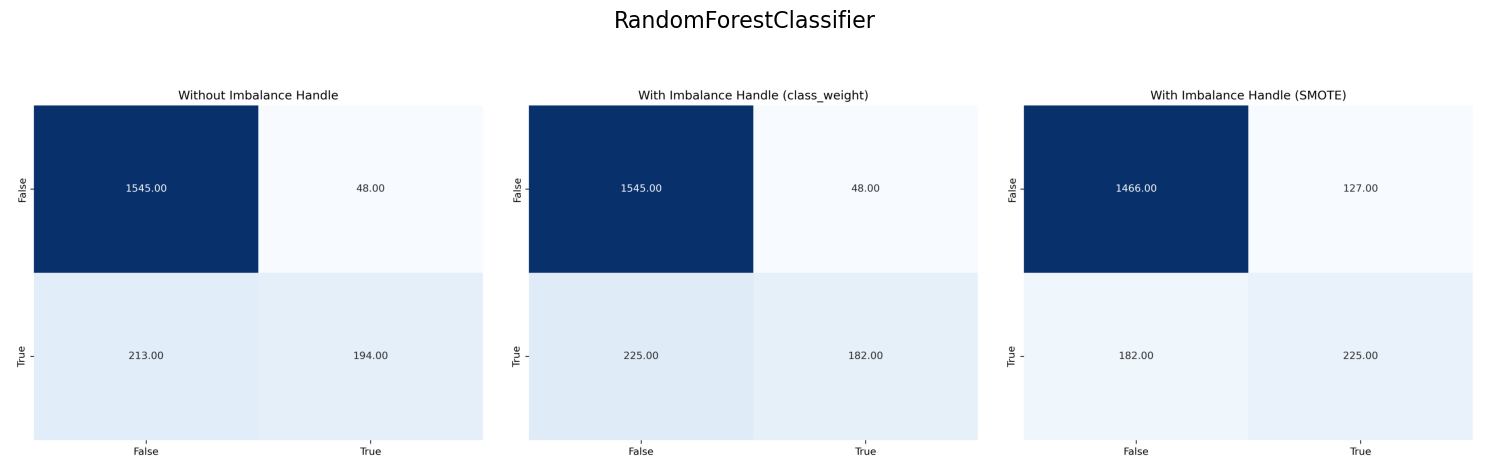

In [28]:
## Combine all conf matrix in one
confusion_matrix_paths = ['./Without Imbalance Handle.png', './With Imbalance Handle (class_weight).png', './With Imbalance Handle (SMOTE).png']

## Load and plot each confusion matrix
plt.figure(figsize=(15, 5))  # Adjust figure size as needed
for i, path in enumerate(confusion_matrix_paths, 1):
    img = Image.open(path)
    plt.subplot(1, len(confusion_matrix_paths), i)
    plt.imshow(img)
    plt.axis('off')  # Disable axis for cleaner visualization


## Save combined plot locally
plt.suptitle(clf_name, fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig(f'conf_matrix.png', bbox_inches='tight', dpi=300)

## Delete old image files
for path in confusion_matrix_paths:
    os.remove(path)